# Project demo

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
import torch
from sktime.distances import distance_factory

In [2]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))

from data_loaders.melbourne_pedestrian import MelbounePedestrianDataModule
from layer_modules.input_layer import ModelWithInputLayer
from models.model_builder import ModelBuilder
from layer_modules.classification_head import ModelWithClassificationHead
from utils.utils_functions import *
from utils.time_series_functions import *

## Config

In [3]:
NOISE_DIM = 100
config = {   
    "dataset_name": "melbourne_pedestrian",
    "dataset_config": {},
    "loader_config": {
                        "batch_size": 32,
                        "num_workers": 20,
                        "pin_memory": True
                    }
}
output_data_dir = os.path.join("..", "data", "melbourne_pedestrian")
model_configs_path = os.path.join("..", "configs", "models")
gen_configs_path = os.path.join(model_configs_path, "generator_InceptionTime.json")
disc_configs_path = os.path.join(model_configs_path, "InceptionTime.json")

gen_ckpt_load_dir = os.path.join("..", "out", "generator0", "version_7", "ckpts")
gan_ckpt_load_dir = os.path.join("..", "out", "gan0", "version_2", "ckpts")

## Creating resources

In [4]:
if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)

data_module = MelbounePedestrianDataModule(config["dataset_config"], loader_config=config["loader_config"])
dataset = data_module.train_dataset
data_loader = data_module.train_dataloader()
it = iter(data_loader)

In [5]:
df = dataset.download_data("test")

In [6]:
gen_config = parse_config(gen_configs_path)
disc_config = parse_config(disc_configs_path)

generator = load_generator(gen_config, data_module)
discriminator = load_discriminator(disc_config, data_module)

Building generator conv1d_generator_InceptionTime...
Building discriminator conv1d_InceptionTime...
Sin cabeza de clasificación('classification_head_params')


In [7]:
centers = {k: {} for k in dataset.unique_labels}
for selected_label in dataset.unique_labels:
    selected_label_indices = df.index[df[0] == selected_label].tolist()
    X = df.loc[selected_label_indices].drop(columns=[0]).values
    barycenter = msm_barycenter_average(X, verbose=False)
    centers[selected_label] = {"X": X,"barycenter": barycenter.tolist(), "mean": np.mean(X, axis=0).tolist()}

## Loading checkpoints

### Generator

In [8]:
checkpoint_path = os.path.join(gen_ckpt_load_dir, os.listdir(gen_ckpt_load_dir)[0])
checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)
gen_state_dict = {key.replace('model.model', 'model').replace('model.ff', 'ff'): value for key, value in checkpoint['state_dict'].items()}
generator.load_state_dict(gen_state_dict)

<All keys matched successfully>

## Generating sample

In [ ]:
def get_msm_fn(target, generated):
    reescaled_target = dataset.inverse_scaler_min_max(target).detach().numpy().reshape(-1)
    reescaled_generated = dataset.inverse_scaler_min_max(generated).detach().numpy().reshape(-1)
    return distance_factory(reescaled_generated, reescaled_target, "msm")

In [30]:
generated, noise, target, labels, total_gen_loss = one_batch_gen(it, generator, data_module.num_classes, gen_config["noise_dim"], L2_LAMBDA=0.5, L1_LAMBDA=0.5)
reescaled_generated = dataset.inverse_scaler_min_max(generated[0]).detach().numpy().reshape(-1)
reescaled_target = dataset.inverse_scaler_min_max(target[0]).detach().numpy().reshape(-1)

total_gen_loss: 0.07664822041988373
l1_loss: 0.12233331799507141
l2_loss: 0.030963120982050896


e:\Informatica\venv312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 24])) that is different to the input size (torch.Size([32, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
e:\Informatica\venv312\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([32, 1, 24])) that is different to the input size (torch.Size([32, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [31]:
msm_distance_fn = distance_factory(reescaled_generated, reescaled_target, "msm")
msm_distance = msm_distance_fn(reescaled_target, reescaled_generated)
print(f"MSM Distance: {msm_distance}")

MSM Distance: 5674.033172607422


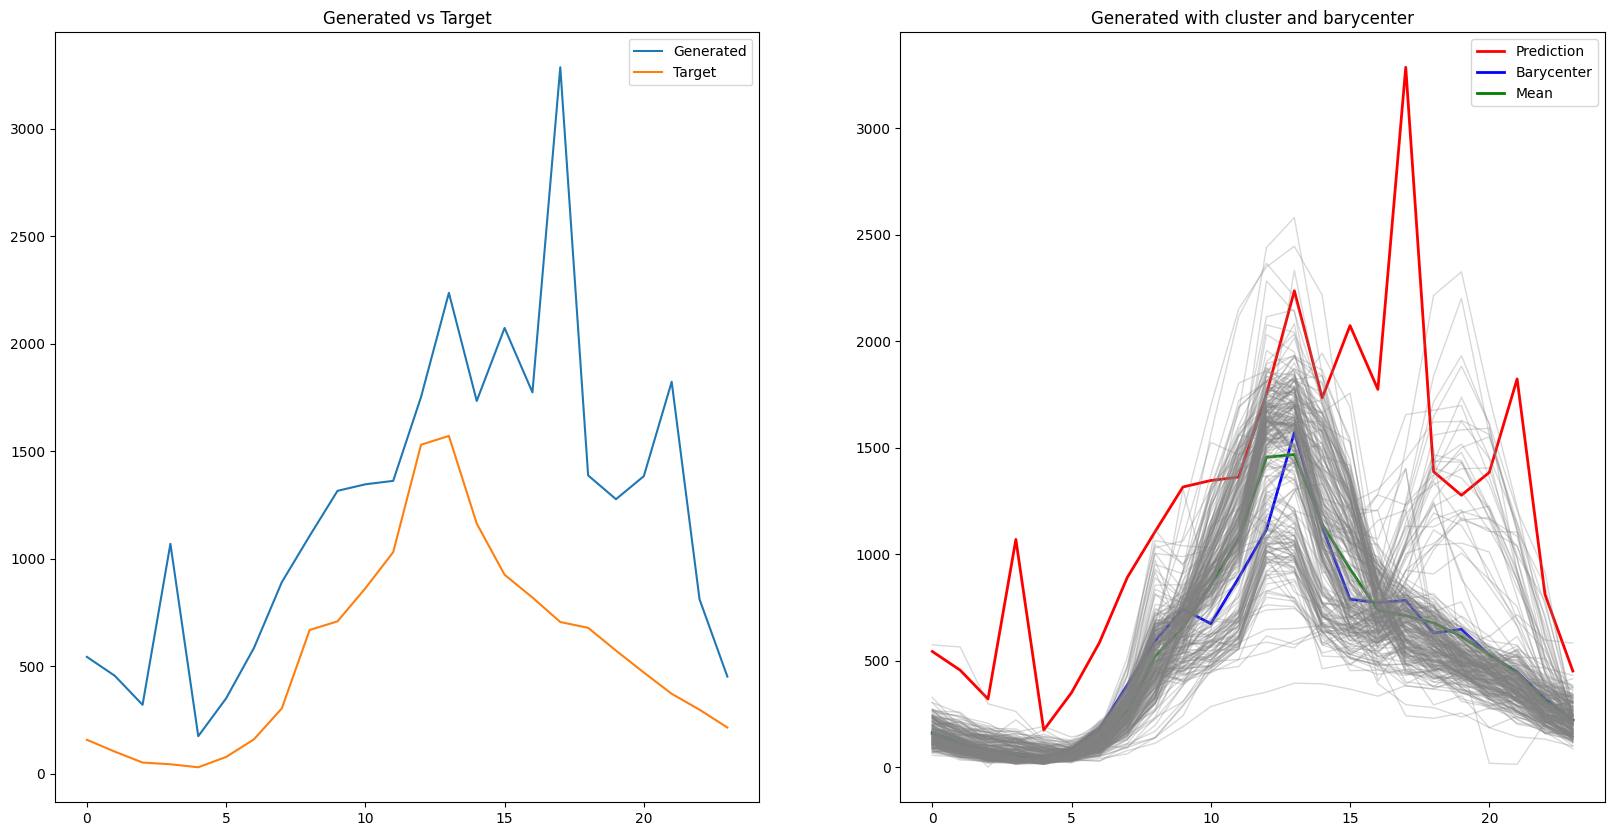

In [32]:
selected_label = float(np.argmax(labels[0]))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Generated vs Target")
ax[0].plot(reescaled_generated)
ax[0].plot(reescaled_target)
ax[0].legend(["Generated", "Target"])
ax[1].set_title("Generated with cluster and barycenter")
ax[1].plot(reescaled_generated, color='red', alpha=1.0, linewidth=2, label='Prediction')
ax[1].plot(centers[selected_label]['barycenter'], color='blue', alpha=1.0, linewidth=2, label='Barycenter')
ax[1].plot(centers[selected_label]['mean'], color='green', alpha=1.0, linewidth=2, label='Mean')
for ts in centers[selected_label]['X']:
    ax[1].plot(ts, color='gray', alpha=0.3, linewidth=1)
ax[1].legend()
plt.show()